In [1]:
import numpy as np
import pandas as pd
import os
import requests
import csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler

!pip install deepchem
import rdkit
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
You should consider upgrading via the 'c:\users\srisk\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [2]:
# Downloading the data from the GitHub repository
if os.path.exists("data.csv"):
  print("Data already downloaded, skipping download....")
else:
  url = 'https://github.com/sriskid/hts_active_learning/raw/main/data.csv'
  res = requests.get(url, allow_redirects=True)
  with open('data.csv','wb') as f:
    print("Downloading data....")
    f.write(res.content)

Data already downloaded, skipping download....


In [3]:
data = []
with open('data.csv', 'r') as csvfile: 
    reader = csv.reader(csvfile, skipinitialspace=True)
    data.append(tuple(next(reader)))
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active))

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [4]:
# Get only the SMILES data
SMILES = []
for i in data:
    SMILES.append(i[1])

In [5]:
SMILES[0:2]

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C ',
 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O ']

## ONE-HOT ENCODING OF SMILES
This will help in vectrorizing smiles data.<br>
This section will use the tokenizer function that is provided in tensorflow, and we will use keras as the front-end to access the function.<br>
Credit: https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles <br>
Inspiration: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [6]:
# Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(SMILES)
# Encoding text_to_sequences
sequences = tokenizer.texts_to_sequences(SMILES)
pad_data = pad_sequences(sequences, maxlen=maxlen)
print ('Encoded string:',pad_data[0])

Encoded string: [ 0  0  0 ...  4  2 10]


In [7]:
#sequences_to_text decodes
print ('Decoded string:',tokenizer.sequences_to_texts(pad_data[0:1]))

Decoded string: ['c 1 ( c 2 c ( [ n H ] c 1 ) c c c ( c 2 ) O C c 1 c c c c c 1 ) C N ( C ) C  ']


In [8]:
def decodeOH2SMILES(array, tokenizer):
    # Converts one-hot encoded sequences back to SMILES strings.
    output = tokenizer.sequences_to_texts(array)
    #Modify this if you change the start or end token.
    disallowed_characters = 'E! '
    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [9]:
decoded_smiles = decodeOH2SMILES(pad_data[0:2],tokenizer)
print(decoded_smiles)

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C', 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O']


## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting smiles data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

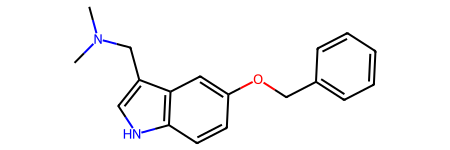

In [10]:
# Drawing molecules
mol = Chem.MolFromSmiles(SMILES[0])
mol

In [11]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(SMILES)):
    mol = Chem.MolFromSmiles(SMILES[i])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
fingerprints = np.array(fingerprints)
fingerprints

[12:07:06] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper (and a previous paper of theirs), they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [12]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [13]:
# Get the B-score values
Bscores = []
active = []
is_active = []
for i in range(len(data)):
    Bscores.append(float(data[i][2]))
    is_active.append(float(data[i][4]))
    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")   
compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

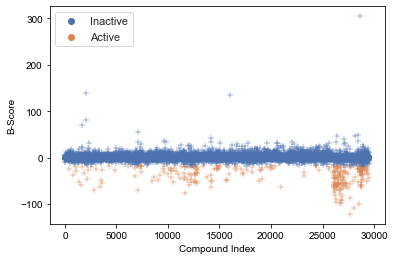

In [14]:
# Visualizing data
# Plot B-scores
fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')
# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

## Query by Committee Implementation

### Creating the Base Learner nad Committee Models

In [15]:
# Creating a Logistic Regression Model Base Learner
class LogR():
    def __init__(self, x, y):
        self.trainX = x
        self.trainY = y
        self.model = LogisticRegression(random_state=0, max_iter=500)

    def fit(self):
        self.model.fit(self.trainX, self.trainY)
        
    def predict(self, x):
        return self.model.predict(x)

    def generate_acc(self, pred, true):
        return accuracy_score(true, pred)
    
    def precision(self, pred, true):
        precision = precision_score(true, pred)
        return precision

    def recall(self, pred, true):
        recall = recall_score(true, pred)
        return recall

    def F1_score(self, pred, true):
        f1 = f1_score(true, pred)
        return f1

In [66]:
# Create Committee Model
class Committee():
  def __init__(self):
    self.classifiers = [DecisionTreeClassifier(min_samples_leaf = 15), # Create the committee members
                        KNeighborsClassifier(),
                        LogisticRegression(max_iter = 500),
                       GaussianProcessClassifier()]
    
  def train(self, X_labeled, y_labeled): # Train all o the committee members 
    for classifier in self.classifiers:
      indices = np.random.choice(range(len(X_labeled)), size=len(X_labeled), replace=True) # Bootstrapping
      X = X_labeled[indices]
      y = y_labeled[indices]
      classifier.fit(X,y)
              
  def predict(self, X_unlabeled):
    predictions = []
    for classifier in self.classifiers:
      predictions.append(classifier.predict(X_unlabeled))
    return np.array(predictions)

  def vote_proba(self, X): # Create a matrix of prediction probabilities usable for labeled and unlabeled data
        votes = np.zeros((len(X), 2))
        for classifier in self.classifiers:
            probs = classifier.predict_proba(X)
            votes += probs
        votes /= len(self.classifiers)
        return votes
    
  def fit_platt_scaling(self, X_labeled, y_labeled): # Performa Platt Scaling
        votes = self.vote_proba(X_labeled)
        self.scaler = LogisticRegression()
        self.scaler.fit(votes[:, 0].reshape(-1, 1), y_labeled)
        
  def predict_proba(self, X_unlabeled): # Gives the scaled prediction probabilities
        votes = self.vote_proba(X_unlabeled)
        return self.scaler.predict_proba(votes[:, 0].reshape(-1, 1))

  def kl_divergence(self, p, q): # Calculate the KL-divergence given two probability distributions
        epsilon = 1e-10
        return np.sum(p * np.log((p + epsilon) / (q + epsilon)))
    
  def disagreement(self, X): # Calculates disagreement between committee memebers Using Average KL-Divergence
        probs = self.predict_proba(X)
        kl_divs = np.zeros((len(X), len(self.classifiers)))
        for i, classifier in enumerate(self.classifiers):
#             print(f"classifier: {classifier:} \n {classifier.predict_proba(X)}")
            kl_divs[:, i] = self.kl_divergence(probs, classifier.predict_proba(X))
        return np.mean(kl_divs, axis=1)

  def hard_vote_probabilities(self, X_unlabeled): # Calculates disagreement between committee memebers Using Hard-vote Entropy
    predictions = self.predict(X_unlabeled)
    hard_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis = 0, arr = predictions)
    probabilities = np.zeros((X_unlabeled.shape[0], np.max(hard_vote) + 1))
    for i in range(len(hard_vote)):
      probabilities[i][hard_vote[i]] = 1
    return probabilities

  def entropy(self, X_unlabeled): # Calculates Entropy if using Hard-Vote Entropy
      probabilities = self.hard_vote_probabilities(X_unlabeled)
      entropy = -np.sum(probabilities * np.log2(probabilities + 1e-6), axis=1)
      return entropy
    
  def disagreement_rate(self, X): # Uses the disagreement rate as a metric for disagreement among committee members
    predictions = self.predict(X)
    disagreement = [1 if len(set(prediction)) > 1 else 0 for prediction in predictions]
    return sum(disagreement) / len(disagreement)
    
  def diagreement_rate_list(self, X_unlabeled):
    batch_size = 1
    return [self.disagreement_rate(X_unlabeled[i:i+batch_size]) for i in range(0, len(X_unlabeled), batch_size)]


### Computing the Simulation

In [67]:
 def initialization(X_resampled, y_resampled, split_ratio = 0.05):
        """Initializes the first labeled samples to which we perform active learning on. Starts with using 5 % of the data 
        as initialization"""
    rand_idx = np.random.permutation(len(X_resampled))
    train_size = round(len(X_resampled)*split_ratio)
    trainX = X_resampled[rand_idx[0:train_size]]
    testX = X_resampled[rand_idx[train_size:len(X_resampled)]]
    trainY = y_resampled[rand_idx[0:train_size]]
    testY = y_resampled[rand_idx[train_size:len(X_resampled)]]
    
    return trainX, testX, trainY, testY

In [68]:

def QBC(X_resampled, y_resampled):
    
    trainX, testX, trainY, testY = initialization(X_resampled, y_resampled) # Initialization
    model = LogR(trainX, trainY)  # Initializing the base learner
    
    accuracies = []
    f1_scores = []
    recalls = []
    precisions = []

    model.fit() # Fitting on the initial instances
    y_pred = model.predict(testX) # Making predictions after training on initial instances

    accuracy = model.generate_acc(y_pred, testY)
    accuracies.append(accuracy)

    f1_score = model.F1_score(y_pred, testY)
    f1_scores.append(f1_score)

    recall = model.recall(y_pred, testY)
    recalls.append(recall)

    precision = model.precision(y_pred, testY)
    precisions.append(precision)
    
    
    committee = Committee() # Initializing committee
    rounds = 0
    while rounds < 474:
      committee.train(trainX, trainY) # Train Committee
      committee.fit_platt_scaling(trainX, trainY) # Platt Scaling
      disagreements = committee.disagreement(testX) # Calculate the disagreement among unobserved instances
#       disagreements = committee.get_average_kld(testX)
      next_data_index = np.argmax(disagreements) # Calculate the unobserved instance with the highest disagreement
      new_x = testX[next_data_index]
      trainX = np.vstack((trainX, new_x)) # Adding instance to observed instances
      testX = np.delete(testX, next_data_index, axis=0)
      new_y = testY[next_data_index]
      testY = np.delete(testY, next_data_index)
      trainY = np.append(trainY, new_y)
      model.trainX = trainX
      model.trainY = trainY
      model.fit() 
      y_pred = model.predict(testX)

      accuracy = model.generate_acc(y_pred, testY)
      accuracies.append(accuracy)

      f1_score = model.F1_score(y_pred, testY)
      f1_scores.append(f1_score)

      recall = model.recall(y_pred, testY)
      recalls.append(recall)

      precision = model.precision(y_pred, testY)
      precisions.append(precision)

      rounds += 1
    accuracies, f1_scores, recalls, precisions = np.array(accuracies), np.array(f1_scores), np.array(recalls), np.array(precisions)

    return accuracies, f1_scores, recalls, precisions

## Running the Simulations

In [70]:
# Run multiple simulations 
from timeit import default_timer as timer

start_timer = timer()

accuracy_matrix = np.empty((10,475)) # Matrices to store values for plotting
f1_matrix = np.empty((10,475))
recall_matrix = np.empty((10,475))
precision_matrix = np.empty((10,475))

rus = RandomUnderSampler(random_state = 10) 
X_resampled, y_resampled = rus.fit_resample(fingerprints, is_active) # Undersampling to handle label imbalance

for simulation in range(10):
    np.random.seed(simulation+10) 
    accuracies, f1_scores, recalls, precisions = QBC(X_resampled, y_resampled)
    accuracy_matrix = np.vstack([accuracy_matrix, accuracies])
    f1_matrix = np.vstack([f1_matrix, f1_scores])
    recall_matrix = np.vstack([recall_matrix, recalls])
    precision_matrix = np.vstack([precision_matrix, precisions])

    print(f"Simulation {simulation} | Accuracy: {accuracies[-1]} | F1 Score: {f1_scores[-1]} | Recall: {recalls[-1]} | Precision: {precisions[-1]}")

end_timer = timer()

print(f"Total time taken for all simulations is {end_timer - start_timer} seconds")

Simulation 0 | Accuracy: 0.3333333333333333 | F1 Score: 0.42857142857142855 | Recall: 0.42857142857142855 | Precision: 0.42857142857142855
Simulation 1 | Accuracy: 0.75 | F1 Score: 0.7692307692307692 | Recall: 0.7142857142857143 | Precision: 0.8333333333333334
Simulation 2 | Accuracy: 0.8333333333333334 | F1 Score: 0.8750000000000001 | Recall: 1.0 | Precision: 0.7777777777777778
Simulation 3 | Accuracy: 0.8333333333333334 | F1 Score: 0.8000000000000002 | Recall: 0.8 | Precision: 0.8
Simulation 4 | Accuracy: 0.75 | F1 Score: 0.6666666666666665 | Recall: 0.6 | Precision: 0.75
Simulation 5 | Accuracy: 0.5833333333333334 | F1 Score: 0.4444444444444445 | Recall: 0.5 | Precision: 0.4
Simulation 6 | Accuracy: 0.6666666666666666 | F1 Score: 0.75 | Recall: 0.8571428571428571 | Precision: 0.6666666666666666
Simulation 7 | Accuracy: 0.75 | F1 Score: 0.7692307692307692 | Recall: 0.8333333333333334 | Precision: 0.7142857142857143
Simulation 8 | Accuracy: 0.5833333333333334 | F1 Score: 0.54545454545

In [71]:
true_acc = accuracy_matrix[10:,:]
true_f1 = f1_matrix[10:,:]
true_recall = recall_matrix[10:,:]
true_precision = precision_matrix[10:,:]

avg_acc = np.mean(true_acc, axis = 0)[-1]
avg_std = np.std(true_acc, axis = 0)[-1]


In [72]:
print("The average accuracy over all simulations =", avg_acc)
print("The standard deviation over all simulations =", avg_std)

The average accuracy over all simulations = 0.7083333333333333
The standard deviation over all simulations = 0.1717960677340692


In [73]:
qbc_acc_std = np.std(true_acc, axis = 0)
qbc_acc_mean = np.mean(true_acc, axis = 0)

qbc_f1_mean = np.mean(true_f1, axis = 0)
qbc_f1_std = np.std(true_f1, axis = 0)

qbc_recall_mean = np.mean(true_recall, axis = 0)
qbc_recall_std = np.std(true_recall, axis = 0)

qbc_precision_mean = np.mean(true_precision, axis = 0)
qbc_precision_std = np.std(true_precision, axis = 0)

In [74]:
# Create a Directory
path = "QBC_Metrics_npys"
if not os.path.exists(path):
    os.mkdir(path)
    print("Folder %s created!" % path)
else:
    print("Folder %s already exists" % path)

Folder QBC_Metrics_npys already exists


In [77]:
# Save the data
np.save(path+"/QBC_Accuracy_platt_mean.npy", qbc_acc_mean)
np.save(path+"/QBC_Accuracy_platt_std.npy", qbc_acc_std)

np.save(path+"/QBC_F1_platt_mean.npy", qbc_f1_mean)
np.save(path+"/QBC_F1_platt_std.npy", qbc_f1_std)

np.save(path+"/QBC_Recall_platt_mean.npy", qbc_recall_mean)
np.save(path+"/QBC_Recall_platt_std.npy", qbc_recall_std)


np.save(path+"/QBC_Precision_platt_mean.npy", qbc_precision_mean)
np.save(path+"/QBC_Precision_platt_std.npy", qbc_precision_std)

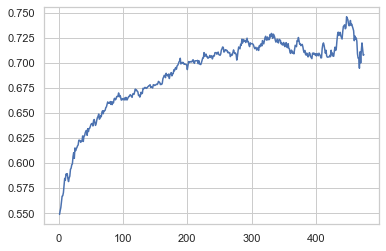

In [76]:
plt.plot(np.arange(1,476,1), qbc_acc_mean)